In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from utils.helper import get_fmri
import matplotlib.pyplot as plt
import numpy as np

In [33]:
v1_sub01 = get_fmri('./data/participants_data_v2021', 'mini_track', 'sub02', 'V1', mean=False)

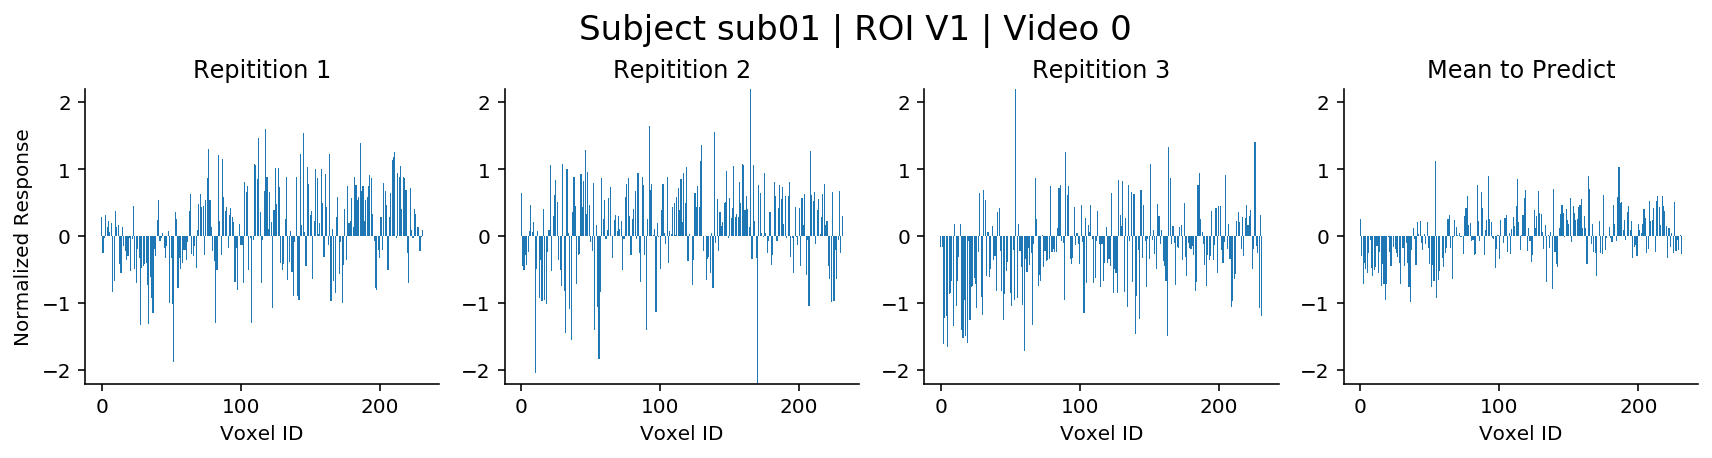

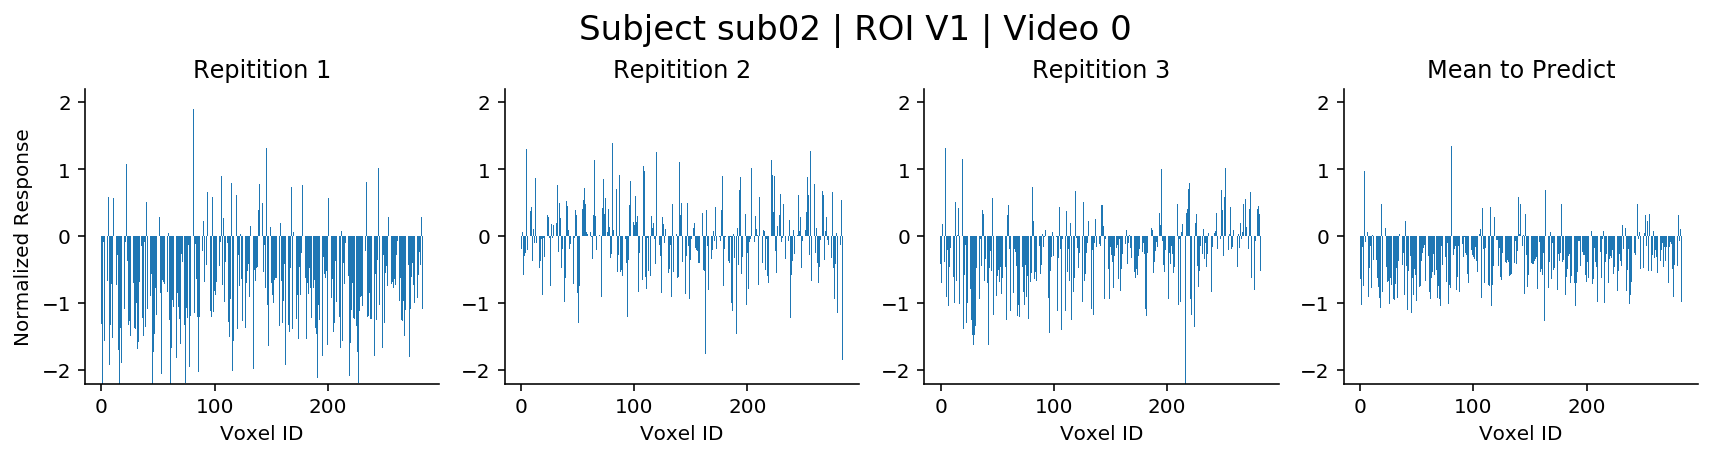

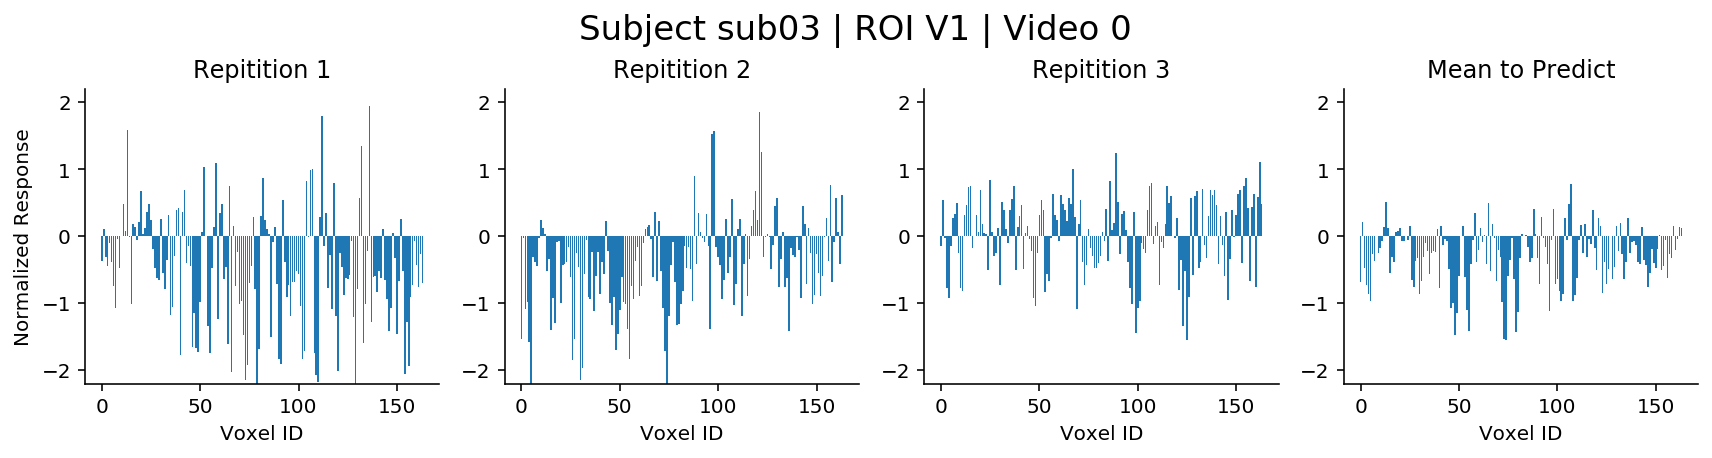

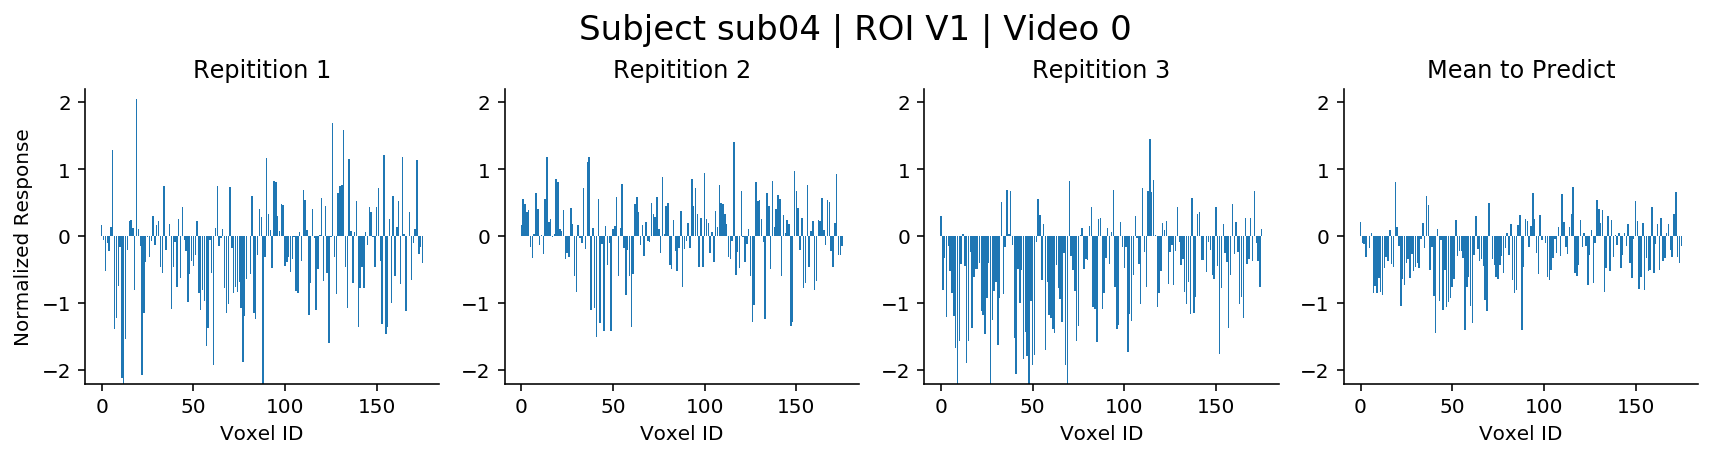

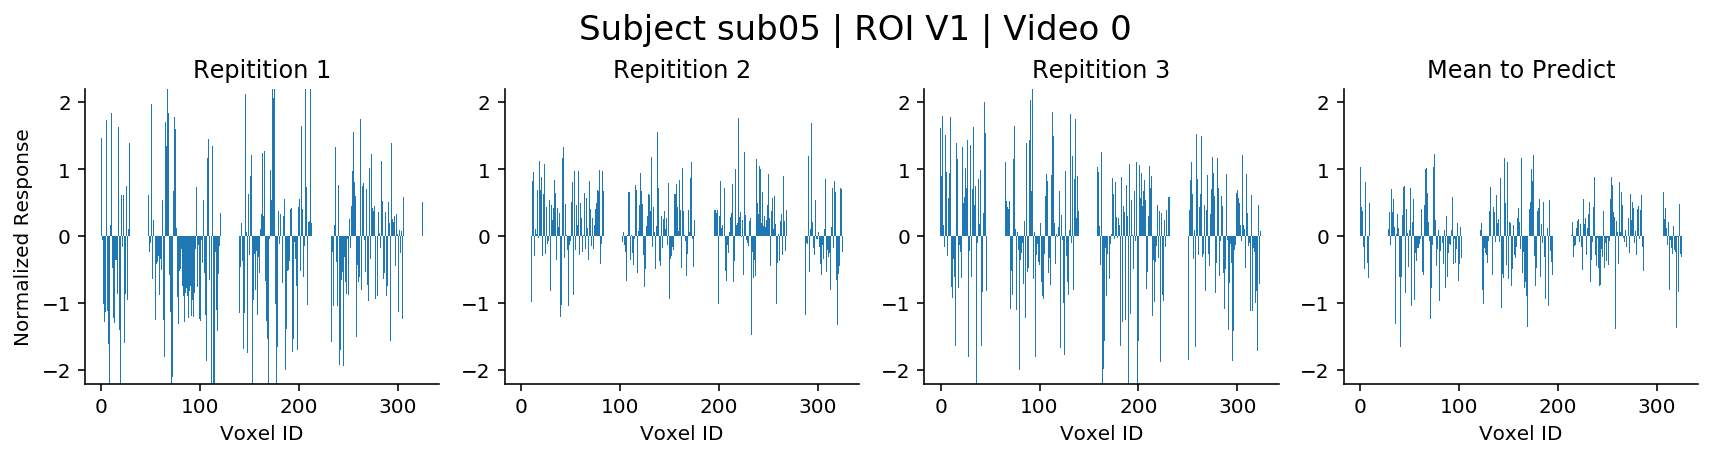

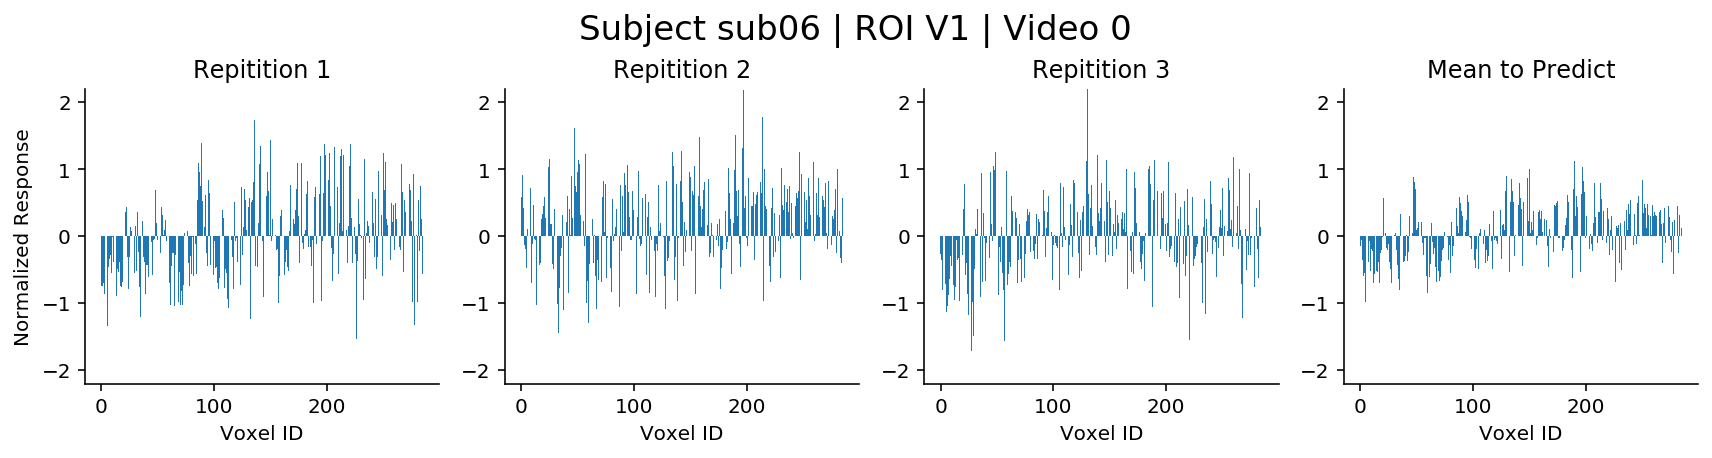

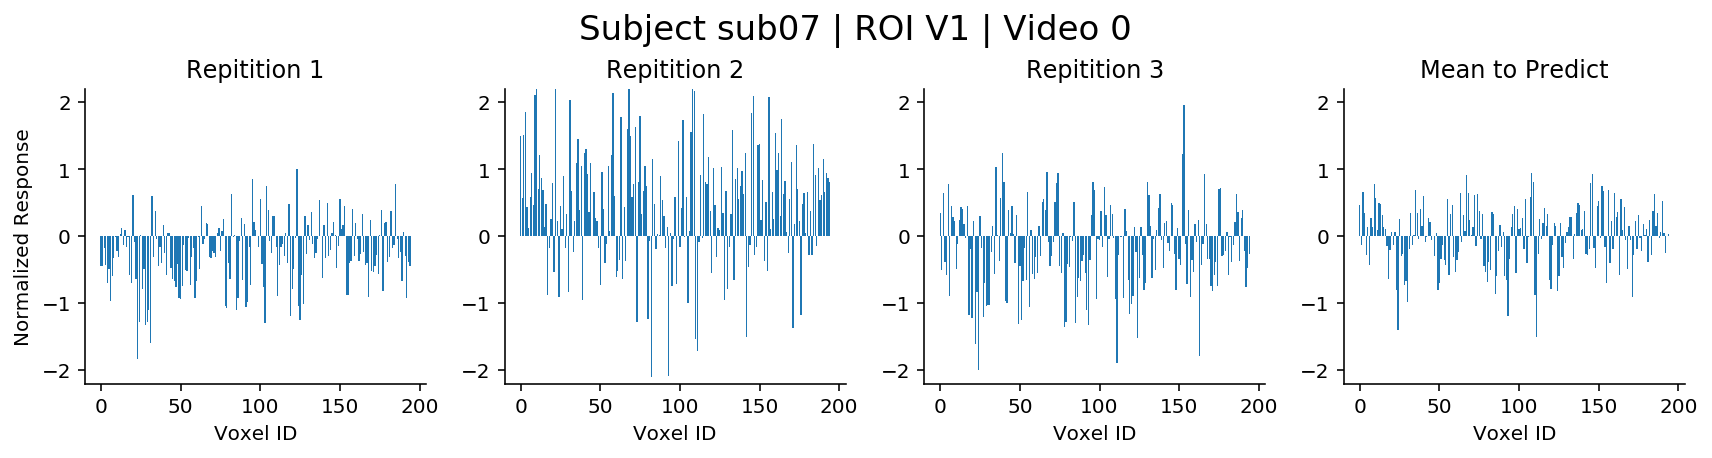

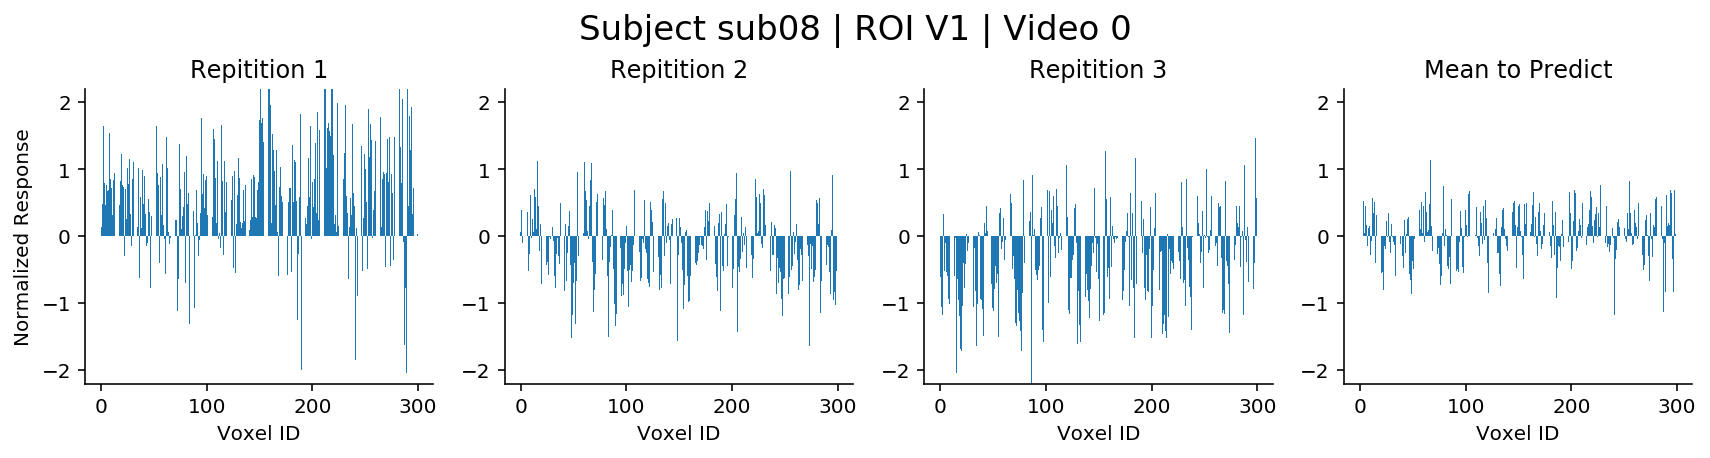

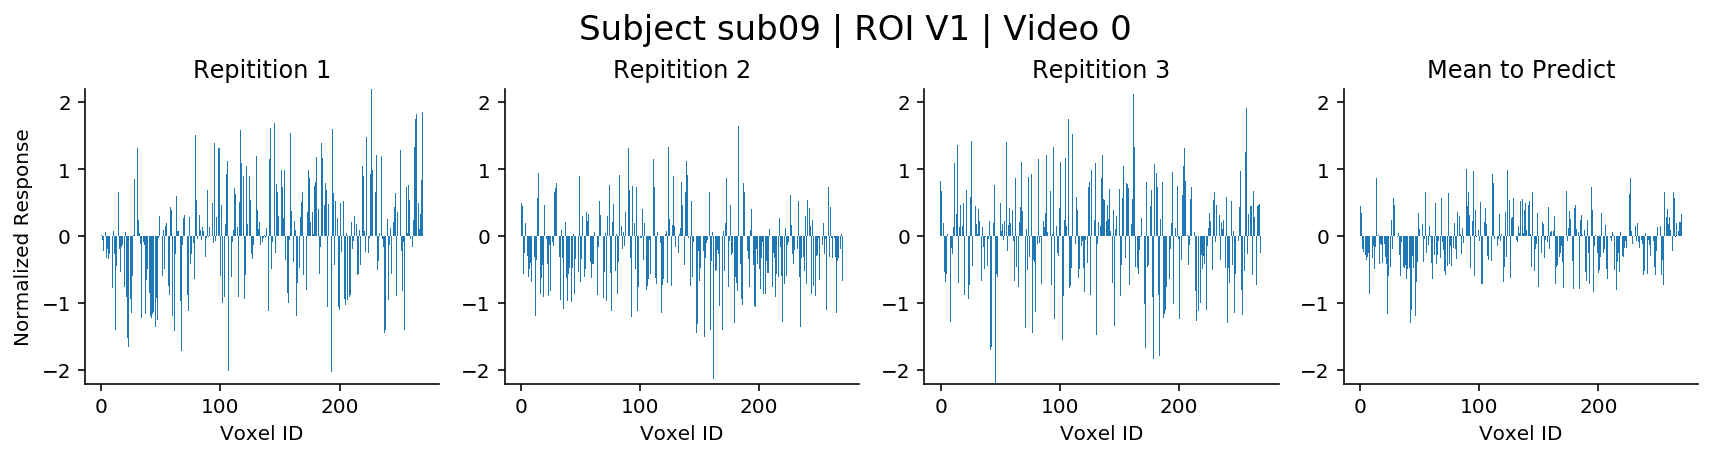

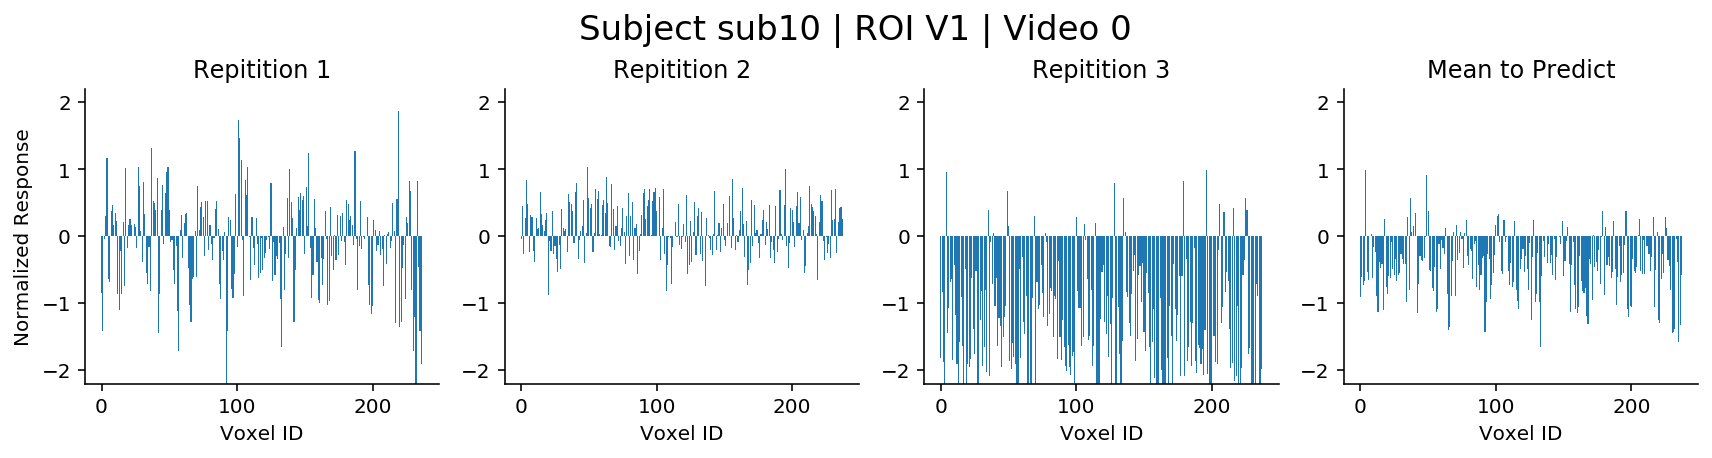

In [68]:
def plot_voxel_response(video_id, track, subject_id, roi='V1'):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.subplots_adjust(top=0.8)
    roi_sub = get_fmri('./data/participants_data_v2021', track, subject_id, roi, mean=False)
    axs.flatten()[0].bar(np.arange(roi_sub.shape[2]), roi_sub[video_id, 0, :])
    axs.flatten()[1].bar(np.arange(roi_sub.shape[2]), roi_sub[video_id, 1, :])
    axs.flatten()[2].bar(np.arange(roi_sub.shape[2]), roi_sub[video_id, 2, :])
    axs.flatten()[3].bar(np.arange(roi_sub.shape[2]), np.mean(roi_sub[video_id], axis=0))
    for i in range(4):
        axs.flatten()[i].set_ylim(-2.2, 2.2)
        axs.flatten()[i].set_xlabel('Voxel ID')
        axs.flatten()[i].spines['top'].set_visible(False)
        axs.flatten()[i].spines['right'].set_visible(False)
    for i in range(3):
        axs.flatten()[i].set_title(f"Repitition {i+1}")
    axs.flatten()[0].set_ylabel('Normalized Response')
    axs.flatten()[3].set_title(f"Mean to Predict")
    fig.suptitle(f"Subject {subject_id} | ROI {roi} | Video {video_id}", y=1.05, fontsize=17)
    fig.tight_layout()
    
    
all_subjects = ['sub01', 'sub02', 'sub03', 'sub04', 'sub05',
                'sub06', 'sub07', 'sub08', 'sub09', 'sub10']
for sub in all_subjects:
    plot_voxel_response(video_id=0, track="mini_track", subject_id=sub, roi='V1')